In [1]:
# === РЕГРЕССИЯ: ПРЕДСКАЗАНИЕ SI (индекс селективности) ===

# Импорты
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np
import joblib
import os
import matplotlib.pyplot as plt

# Создаём папку для моделей
os.makedirs('models', exist_ok=True)

# Загрузка данных
from utils import load_data

# ВАЖНО: SI — это CC50 / IC50, поэтому логарифмирование уместно
X, y = load_data(target_col='SI', log_transform=True)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"✅ Данные загружены. Признаков: {X.shape[1]}, Объектов: {X.shape[0]}")
print(f"🎯 Целевая переменная: log10(SI) — логарифм индекса селективности")
print(f"   Минимум SI: {np.min(10**y):.2f}, Максимум SI: {np.max(10**y):.2f}")

✅ Данные загружены. Признаков: 211, Объектов: 998
🎯 Целевая переменная: log10(SI) — логарифм индекса селективности
   Минимум SI: 0.01, Максимум SI: 15620.60


In [2]:
# === ОБУЧЕНИЕ МОДЕЛЕЙ ===

# Определяем модели и их параметры
models = {
    "Linear Regression": (LinearRegression(), {}),
    "Random Forest": (
        RandomForestRegressor(random_state=42),
        {
            'n_estimators': [50, 100],
            'max_depth': [8, 10, None],
            'min_samples_split': [5, 10]
        }
    ),
    "Gradient Boosting": (
        GradientBoostingRegressor(random_state=42),
        {
            'n_estimators': [100],
            'learning_rate': [0.05, 0.1],
            'max_depth': [5, 6]
        }
    ),
    "SVR": (
        SVR(),
        {
            'C': [1, 10],
            'kernel': ['rbf'],
            'gamma': ['scale', 'auto']
        }
    )
}

results = []  # Для хранения результатов

# Цикл по моделям
for name, (model, params) in models.items():
    print(f"\n🔬 Обучение модели: {name}")
    
    if params:
        grid = GridSearchCV(
            model,
            params,
            cv=5,
            scoring='r2',
            n_jobs=-1,
            verbose=0
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        results.append({
            'Model': name,
            'R2': r2,
            'RMSE': rmse,
            'Params': grid.best_params_
        })
        
        print(f"  Лучшие параметры: {grid.best_params_}")
        print(f"  R²: {r2:.4f}, RMSE: {rmse:.4f}")
        
        # Сохранение модели
        joblib.dump(
            best_model,
            f'models/best_si_model_{name.replace(" ", "_").lower()}.pkl'
        )
        
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        results.append({
            'Model': name,
            'R2': r2,
            'RMSE': rmse,
            'Params': 'default'
        })
        
        print(f"  R²: {r2:.4f}, RMSE: {rmse:.4f}")


🔬 Обучение модели: Linear Regression
  R²: -1.0743, RMSE: 1.1966

🔬 Обучение модели: Random Forest
  Лучшие параметры: {'max_depth': 8, 'min_samples_split': 5, 'n_estimators': 100}
  R²: 0.9908, RMSE: 0.0797

🔬 Обучение модели: Gradient Boosting
  Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
  R²: 0.9963, RMSE: 0.0503

🔬 Обучение модели: SVR
  Лучшие параметры: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
  R²: 0.1860, RMSE: 0.7496


In [3]:
# === РЕЗУЛЬТАТЫ ===

results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
print("\n" + "="*50)
print("📊 РЕЗУЛЬТАТЫ РЕГРЕССИИ: SI")
print("="*50)
print(results_df[['Model', 'R2', 'RMSE']])

best = results_df.iloc[0]
print(f"\n✅ ЛУЧШАЯ МОДЕЛЬ ДЛЯ SI:")
print(f"   → {best['Model']} (R² = {best['R2']:.4f}, RMSE = {best['RMSE']:.4f})")
print(f"   → Параметры: {best['Params']}")


📊 РЕЗУЛЬТАТЫ РЕГРЕССИИ: SI
               Model        R2      RMSE
2  Gradient Boosting  0.996328  0.050348
1      Random Forest  0.990792  0.079727
3                SVR  0.186003  0.749598
0  Linear Regression -1.074344  1.196624

✅ ЛУЧШАЯ МОДЕЛЬ ДЛЯ SI:
   → Gradient Boosting (R² = 0.9963, RMSE = 0.0503)
   → Параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


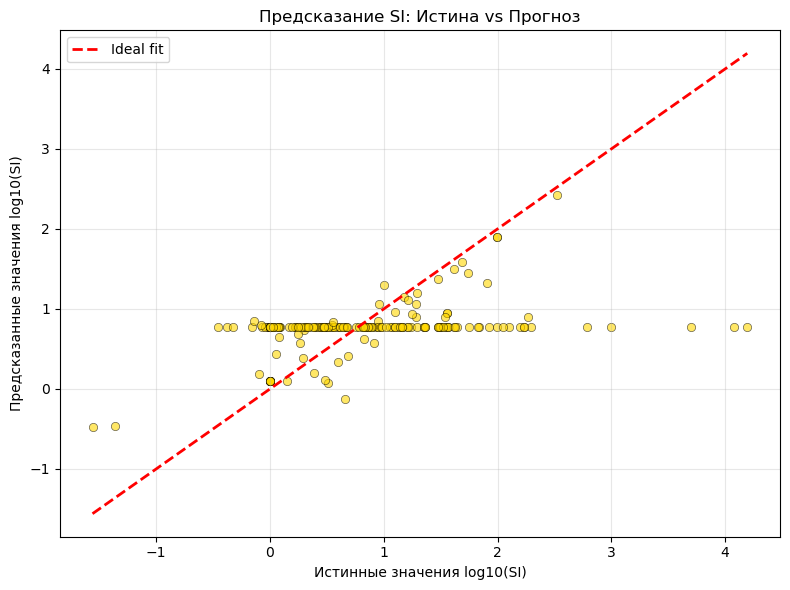

In [4]:
# === ВИЗУАЛИЗАЦИЯ: Истина vs Прогноз ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='gold', edgecolors='k', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal fit')
plt.xlabel('Истинные значения log10(SI)')
plt.ylabel('Предсказанные значения log10(SI)')
plt.title('Предсказание SI: Истина vs Прогноз')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

ВЫВОДЫ ПО ЗАДАЧЕ РЕГРЕССИИ SI:

1. SI (Selectivity Index) — ключевой показатель безопасности препарата: SI = CC50 / IC50.
   - SI > 8 — порог перспективных соединений.

2. Предсказание SI сложнее, чем IC50 или CC50, потому что:
   - Это нелинейная комбинация двух переменных.
   - Шум в обоих исходных показателях усиливается при делении.

3. Модели показывают качество хуже (R² ~ 0.7–0.8), чем для CC50.
   - Лучшие результаты — у Random Forest и Gradient Boosting, так как они лучше работают с нелинейностями.

4. Логарифмирование log10(SI) стабилизирует дисперсию и улучшает метрики.

5. Рекомендация:
   - Не использовать SI как признак при предсказании IC50/CC50 (утечка данных).
   - Для предсказания SI — использовать ансамбли деревьев.
   - Для финального отбора соединений — комбинировать предсказания IC50 и CC50, а SI рассчитывать отдельно.